##### Jupyter Notebook
>venv: source bin/activate
>jupyter notebook
>ctrl-c
>deactivate

## 0. Import Libraries & Parameters

### 0.1 Jupyter notebook imports

In [ ]:
# for jupyter notebook
# !pip install --upgrade pip
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install statsmodels
# !pip install pmdarima
# !pip install fpdf
# !pip install darts

### 0.2 Python & Scikit Learn libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from functions import *

### 0.3 Experiment parameters

In [ ]:
def load_previous_experiment(filename:str):
    with open(filename, 'r') as f:
        previous_experiment = json.load(f)
        return previous_experiment

previous_experiment = '230607_kakao_exp_01.json'
experiment_parameters = load_previous_experiment('/work/deepnote_exports/' + previous_experiment)
display(experiment_parameters)

{'experiment_name': 'kakao_exp_01',
 'dataset': 'kakao_A.csv',
 'problem_type': 'timeseries',
 'experiment_parameters': {'n_splits': 5,
  'scoring': 'accuracy',
  'target': 'sales',
  'categorical_columns': [],
  'date_columns': ['date'],
  'feature_selection': {'date': True,
   'feat_a': True,
   'feat_b': True,
   'feat_c': True,
   'feat_d': True,
   'feat_e': True,
   'feat_f': True,
   'sales': True}},
 'selected_classifiers': {'DT': {'include': True,
   'default': 'DT',
   'params': {'ccp_alpha': [0.1, 0.01, 0.001],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8, 9],
    'max_features': ['sqrt', 'log2']},
   'best_params': {'ccp_alpha': 0.001,
    'criterion': 'entropy',
    'max_depth': 9,
    'max_features': 'sqrt'},
   'best_score': 0.6847981821735731,
   'cross_val_scores': {'mean_cross_val_accuracy': 0.6847981821735731,
    'mean_cross_val_precision': 0.723145209003637,
    'mean_cross_val_recall': 0.5693053311793215,
    'mean_cross_val_f1': 0.6348494621

### 0.4 Experiment options

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

run = {
    'all': False,
    'data_exploration': False,
    'auto_regression_models': False,
    'arima_sarima': False,
    'sarimax': False,
    'machine_learning_models': False,
    'dtregressor': False,
    'mlpregressor': False,
    'recursive_multi_step_forecasting': False,
    'deep_learning_models': False,
    'darts': False,
    'darts_arima': False,
    'darts_exponential_smoothing': False,
    'darts_regressor': False,
    'submission': True,
    'experiment_pipeline': False,
    '_incl_analyse_results': False,
    '_incl_save_experiment': False,
    'final_test': False,
    '_incl_save_final_test': False
}

model_mapping = {
    'DT': DecisionTreeClassifier(random_state=0),
    'MLP': MLPClassifier(random_state=0, max_iter=1000)
}

# Introduction

## 1. Data Import

### 1.0 Import data & convert to datetime
* Convert date string to datetime datatype when importing the csv file

In [ ]:
def import_time_series(csv_file:str, index_col:str, parse_dates:list):
    df = pd.read_csv(csv_file, index_col=index_col, parse_dates=parse_dates)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    df.sort_index(inplace=True,ascending=True)
    return df

df = import_time_series(experiment_parameters['dataset'], index_col='date', parse_dates=experiment_parameters['experiment_parameters']['date_columns'])
print(f"Shape of data: {df.shape}")
df

Shape of data: (1065, 7)


,feat_a,feat_b,feat_c,feat_d,feat_e,feat_f,sales
date,,,,,,,
2019-01-01,14945660,83470,1591,220,1351,911411,17425701
2019-01-02,19226542,79779,8699,238,1420,1995960,17013518
2019-01-03,20386487,78938,437,244,1363,2488056,16796881
2019-01-04,21885288,82317,8182,239,1837,2411262,17257373
2019-01-05,16547256,75180,7502,230,1705,2578383,14697297
...,...,...,...,...,...,...,...
2021-11-26,28273300,94126,6574,327,3898,7075691,23686756
2021-11-27,20090058,85331,1825,312,3452,3896014,22723865
2021-11-28,19918007,86572,7129,304,3667,3584937,22762015


### 1.1 Split into train, test datasets
* Best practice is to split data into train and test datasets right away
* All pre-processing and feature selection should be determined only using the train dataset to prevent any data leakage 

In [ ]:
from sklearn.model_selection import train_test_split

forecast_length = 31
df_train, df_test = train_test_split(df, test_size=forecast_length, shuffle=False)
train_period = df_train.index
test_period = df_test.index

dataset = {
    'service': 'A',
    'df_train': df_train,
    'df_test': df_test,
    'train_period': train_period,
    'test_period': test_period    
}

print(df_train.shape)
print(df_test.shape)

(1034, 7)
(31, 7)


### 1.2 Check for missing data
* Zeros represent missing data points in the time series (stipulated in assignment)

In [ ]:
def check_signs(df:pd.DataFrame):
    number_signs = [((df[column] > 0).sum(), (df[column] == 0).sum(), (df[column] < 0).sum()) for column in df.columns if df[column].dtype != 'datetime64[ns]']
    df_result = pd.DataFrame(
        number_signs, 
        index = [column for column in df.columns if df[column].dtype != 'datetime64[ns]'],
        columns = ['positive values', 'zero values', 'negative values']
        )
    return df_result

print("df_train")
print(check_signs(df_train))
print()
print("df_test")
print(check_signs(df_test))

df_train
        positive values  zero values  negative values
feat_a             1034            0                0
feat_b             1034            0                0
feat_c             1034            0                0
feat_d             1034            0                0
feat_e             1034            0                0
feat_f             1034            0                0
sales              1034            0                0

df_test
        positive values  zero values  negative values
feat_a               31            0                0
feat_b               31            0                0
feat_c               31            0                0
feat_d               31            0                0
feat_e               31            0                0
feat_f               31            0                0
sales                31            0                0


## 2. Data Exploration
* Auto regressive models require training data to be stationary 
  (mean and variance do not vary over time)
* Use charts to check time series for stationarity by identifying trends, seasonality or cyclicality


### 2.0 Visual inspection using lineplots
* Examine moving average (blue) and standard deviation (pink) to check if mean and variance change over time

In [ ]:
if run['all'] or run['data_exploration']:

    get_visualisation_plots(df_train, figsize=(7,10), style='default')
    # print(df.columns[0])

### 2.1 Check feature correlations
* Highly correlated features can be considered to be dropped to avoid redundant data and to reduce dimensionality

In [ ]:
if run['all'] or run['data_exploration']:

    get_feature_correlations(df_train, figsize=(5,4))

### 2.2 Check time series for seasonality
* Use visual charts to identify seasonality

In [ ]:
if run['all'] or run['data_exploration']:

    for feat in df_train.columns:
        get_seasonal_plots(df_train[feat], figsize=(7,6), style='default')
        get_seasonal_plots(df_train[feat], figsize=(7,6), style='default')  

### 2.3 Decompose seasonality
* Use the ADF statistic to check for stationarity
* Can decompose dataset into trend, seasonality and residuals to check stationarity including seasonality or removing seasonality

In [ ]:
if run['all'] or run['data_exploration']:

    for feat in df_train.columns:
        get_decompose_seasonality(df_train[feat], model='additive', period=None, figsize=(12, 16), style='default')
        get_decompose_seasonality(df_train[feat], model='multiplicative', period=None, figsize=(12, 16), style='default')   

### 2.4 Find seasonality period using autocorrelation plots
* Autocorrelation plots can also identify seasonality
* Can select various durations to smooth charts for both additive and multiplicative seasonality

In [ ]:
if run['all'] or run['data_exploration']:

    for feat in df_train.columns:
        get_various_seasonality(df_train[feat], model='additive', periods=[7,28,84,182,364], figsize=(8,8), style='default')
        get_various_seasonality(df_train[feat], model='multiplicative', periods=[7,28,84,182,364], figsize=(8,8), style='default')

### 2.5 Transform to stationary data using differencing
* Use ADF statistic to check features for stationarity and use differencing to make data stationary
* Usually first or second order differencing can transform non-stationary data into stationary data

In [ ]:
if run['all'] or run['data_exploration']:

    for feat in df_train.columns:
        get_various_stationarity(df_train[feat], differencing=[1,2], figsize=(8,4*5), deseasonalise=True, model='additive', style='default')

## 3. Auto Regression Models
* There is no future data leakage when using the ARIMA and SARIMA models because both do not require df_test data (ie, future values) to make predictions
* The SARIMAX model, however, risks data leakage if the exogenous inputs are taken directly from df_test
* Use separate ARIMA/SARIMA models to predict forecasts for individual features when used as inputs for the SARIMAX model to avoid data leakage 

### 3.0 ARIMA, SARIMA & SARIMAX models
* Use the pmdarima package to find the best model by autofitting regressive models
* auto_arima will find best values for (p,d,q) for ARIMA and (p,d,q)(P,D,Q)[m] for SARIMA/SARIMAX
* Seasonality period m assumption is the one parameter that can be set separately in the SARIMA model by extending the ARIMA to include seasonality by setting seasonal=True
* Check model using traditional metrics (mean_absolute_error, mean_absolute_percentage_error & root mean-squared error)

In [ ]:
# project assumptions
service = 'A'
target = 'sales'

### 3.1 Autofit non-seasonal ARIMA & seasonal SARIMA models

In [ ]:
if run['all'] or run['auto_regression_models'] or run['arima_sarima']:

    exp_arima_sarima = [
        ("A", dataset, "arima", "sales", False, 1, False, None, None),
        ("A", dataset, "arima_scaled", "sales", False, 1, True, None, None),
        ("A", dataset, "sarima", "sales", True, 7, False, None, None),
        ("A", dataset, "sarima_scaled", "sales", True, 7, True, None, None),
        ]
    
    for param in exp_arima_sarima:
        arima_sarima = do_arima(*param)

### 3.2 Autofit SARIMAX model
* The SARIMAX model extends the SARIMA model by adding exogenous variables or external factors
* Feature selection and feature engineering can be applied to these additional features to improve forecast quality


#### 3.2.0 Feature selection & feature engineering
* ACF/PACF autocorrelation plots used to ensure any feature values are statistically significant
* If no values are statistically significant then the data can be consider white noise
* The m seasonality period can be estimated by running a seasonal decomposition and then plotting the autocorrelation results to identify any statistical significance
* Scaling can be also be used for equal treatment of features

In [ ]:
if run['all'] or run['auto_regression_models'] or run['sarimax']:
    
    import statsmodels.api as sm
    from pandas.plotting import autocorrelation_plot
    import pmdarima as pmd
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller

    def screen_features_for_white_noise(target, cutoff=10, alpha=0.05):
        features = []
        for col in df_train.columns: 
            acf, a_ci = sm.tsa.acf(df_train[col], alpha=0.05)
            pacf, p_ci = sm.tsa.pacf(df_train[col], alpha=0.05)
            a_valid = ((abs(a_ci/acf[:,np.newaxis] - 1)) < 1).sum()/2
            p_valid = ((abs(p_ci/pacf[:,np.newaxis] - 1) < 1)).sum()/2
            if (a_valid > 10 or p_valid > 10) and col != target:
                features.append(col)
        return features

    def get_various_seasonality(dataset, model='additive', periods=[7,30,120,365], figsize=(8,6), style='default'):
        ncharts = len(periods)
        if ncharts%2 > 0:
            rows = int(ncharts/2 + 0.5)
        else:
            rows = int(ncharts/2)
        if not isinstance(dataset, pd.Series):
            dataset = pd.Series(dataset)
        with plt.style.context(style=style):
            plt.rcParams["font.size"] = 7
            plt.rcParams['lines.linewidth'] = 0.5
            plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#e377c2", "#2ca02c", "#bcbd22"])
            fig = plt.figure(figsize=figsize, constrained_layout=True)
            grid = fig.add_gridspec(nrows=rows, ncols=2)
            num_periods = 0
            for row in range(rows):
                for col in range(2):
                    ax = fig.add_subplot(grid[row,col])
                    decompose = seasonal_decompose(dataset, model=model, period=periods[num_periods])
                    if model == 'multiplicative':
                        deseason = (decompose.observed / decompose.seasonal).astype(int)
                    else:
                        deseason = (decompose.observed - decompose.seasonal).astype(int)
                    autocorrelation_plot(deseason.tolist(), ax=ax)
                    ax.set_title(f"Feature: {dataset.name}\nModel: {model}\n Period: {periods[num_periods]}")
                    if num_periods < ncharts - 1:
                        num_periods += 1
                    else:
                        break
            plt.show()

    # features = screen_features_for_white_noise(target, cutoff=10, alpha=0.05)
    # print(features)

    # for feat in df_train.columns:
    #     get_various_seasonality(df_train[feat], model='additive', periods=[7,30,90], figsize=(8,6), style='default')

#### 3.2.1 Fit exogenous variables to fit SARIMAX
* Fit separate ARIMA/SARIMA models for each feature to use forecasted data as exogenous variables for the SARIMAX model to avoid future data leakage
* Use feature selection and set the seasonality period for individual features when generating the SARIMA forecasts for the SARIMAX model
* Scaling can also be used when generating forecasted variables for the SARIMAX model

In [ ]:
if run['all'] or run['auto_regression_models'] or run['sarimax']:

    from sklearn.preprocessing import MinMaxScaler

    # sarimax using text_X
    exp_sarimax = [
        [(["feat_a", "feat_b", "feat_d", "feat_e", "feat_f"], False), ("A", dataset, "test_X_sarimax", "sales", True, 7, False)],
        [(["feat_a", "feat_b", "feat_d", "feat_e", "feat_f"], True), ("A", dataset, "test_X_sarimax_scaled", "sales", True, 7, True)]
    ]

    # do SARIMAX using test_X and text_X with scaling
    def get_exp_test_X(features, scaled=False):
        train_X, train_y = get_X_y(target, df_train.copy())
        test_X, test_y = get_X_y(target, df_test.copy())
        if scaled:
            scaler_X = MinMaxScaler()
            scaled_exp_train_X = scaler_X.fit_transform(train_X[features])
            scaled_exp_test_X = scaler_X.transform(test_X[features])
            scaled_exp_test_X = pd.DataFrame(scaled_exp_test_X, index=test_X.index, columns=features)
            return scaled_exp_test_X
        else:
            exp_test_X = test_X[features]
            return exp_test_X
    
    for param in exp_sarimax:
        exp_test_X = get_exp_test_X(*param[0])
        sarimax_forecasts = do_arima(*param[1], X_forecasts=exp_test_X, features=exp_test_X.columns)


    # sarimax using predicted values for test_X and scaled predicted values for text_X_scaled
    exp_pred_sarimax = [
        [
            (["feat_a", "feat_b", "feat_d", "feat_e", "feat_f"], [7,7,30,30,30], 0.10, False),
            ("A", dataset, "predicted_sarimax", "sales", True, 7)
        ],
        [
            (["feat_a", "feat_b", "feat_d", "feat_e", "feat_f"], [7,7,30,30,30], 0.10, False),
            ("A", dataset, "predicted_sarimax_scaled", "sales", True, 7, True)
        ],
    ]

    # do SARIMA for each selected feature
    def get_predicted_test_X(features, seasonality, cutoff, scaled=False):
        predicted_test_X = pd.DataFrame()
        for i, feat in enumerate(features):
            if scaled:
                forecasts, mape = do_arima(service, dataset, model_type=f"sarima_scaled_{feat}", target=feat, seasonal=True, m=seasonality[i], scaled=True)
            else:
                forecasts, mape = do_arima(service, dataset, model_type=f"sarima_{feat}", target=feat, seasonal=True, m=seasonality[i], scaled=False)
            if mape > cutoff:
                predicted_test_X[feat] = forecasts
        return predicted_test_X

    # for param in exp_pred_sarimax:
    #     predicted_test_X = get_predicted_test_X(*param[0])
    #     sarimax = do_arima(*param[1], predicted_test_X, predicted_test_X.columns)

    # sarimax_forecasts = do_arima(service, dataset, model_type="predicted_sarimax", target=target, seasonal=True, m=7, scaled=False, X_forecasts=predicted_test_X, features=features)
        
    # do SARIMA for each selected feature with scaling
    # predicted_test_X = pd.DataFrame()
    # for i, feat in enumerate(features):
    #     scaled_forecasts, forecasts = do_arima(service, dataset, model_type=f"scaled_sarima_{feat} seasonality_{seasonality[i]}", target=feat, seasonal=True, m=seasonality[i], scaled=True)
    #     predicted_test_X[feat] = scaled_forecasts
    # print(predicted_test_X)
    # sarimax_forecasts = do_arima(service, dataset, model_type="predicted_scaled_sarimax", target=target, seasonal=True, m=7, scaled=True, X_forecasts=predicted_test_X, features=features)


## 4. Machine Learning Models
* Recursive multi-step forecasting avoids future data leakage by doing a one-step forecast of the target and then using this forecasted target value to recursively update input variables (based off the target)
* This allows the building forecasts across the forecast period only using information available at prediction time 
* Use GridSearchCV and time series cross validation to find hyperparameters for the best model
* Using independent features requires individual forecasts for each so DART of SKTIME libraries are used to apply recursive multi-step forecasting to all exogenous features

### 4.0 DecisionTree & MultiLayerPerceptron models
* Use GridSearchCV and time series cross validation to find hyperparameters for the best model
* Set scoring to root_mean_squared_error (RMSE) or mean_absolute_error (MAE)
* Use MinMaxScaler to scale features for MLPRegressor
* Check model using traditional metrics (mean_absolute_error, mean_absolute_percentage_error & root mean-squared error) after reversing the scaler transform used for the MLPRegressor

In [ ]:
# project assumptions
service = 'A'
target = 'sales'

### 4.1 Fit DecisionTree model

In [ ]:
if run['all'] or run['machine_learning_models'] or run['dtregressor']:

    selected_model_dt = {
        'name': 'DT',
        'model': DecisionTreeRegressor(random_state=42),
        # 'param_grid': {
        #     'criterion': ['squared_error'],
        #     'splitter': ['best','random'],
        #     'max_depth': [None,40,50,60],
        #     'min_samples_leaf': [1,5,8,10],
        #     'min_weight_fraction_leaf': [0.0,0.1],
        #     'max_features': [None,'auto'],
        #     'max_leaf_nodes': [None,150,200,250]
        #     }
        'param_grid': {
            'criterion': ['squared_error'],
            'splitter': ['random'],
            'max_depth': [50],
            'min_samples_leaf': [8],
            'min_weight_fraction_leaf': [0.0],
            'max_features': [None],
            'max_leaf_nodes': [200]
            }
    }

    exp_dt = [
        ("A", dataset, selected_model_dt, "sales", 28, False, False),
        ("A", dataset, selected_model_dt, "sales", 28, True, False),
        ("A", dataset, selected_model_dt, "sales", 28, False, True),
        ("A", dataset, selected_model_dt, "sales", 28, True, True)
    ]

    for param in exp_dt:
        do_ml(*param)

### 4.2 Fit MultiLayerPerceptron model

In [ ]:
if run['all'] or run['machine_learning_models'] or run['mlpregressor']:

    selected_model_mlp = {
        'name': 'MLP',
        'model': MLPRegressor(random_state=42),
        # 'param_grid': {
        #     'hidden_layer_sizes': [(100,),(50,),(50,50), (100,50)],
        #     'activation': ['relu','tanh'],
        #     'solver': ['adam','lbfgs'],
        #     'alpha': [0.0001,0.001,0.01],
        #     'learning_rate': ['constant','adaptive']
        #     },
        'param_grid': {
            'hidden_layer_sizes': [(50,50)],
            'activation': ['relu'],
            'solver': ['lbfgs'],
            'alpha': [0.01],
            'learning_rate': ['constant'],
            'max_iter': [200]
            }
    }

    exp_mlp = [
        ("A", dataset, selected_model_mlp, "sales", 28, False, False),
        # ("A", dataset, selected_model_mlp, "sales", 28, True, False),
        # ("A", dataset, selected_model_mlp, "sales", 28, False, True),
        # ("A", dataset, selected_model_mlp, "sales", 28, True, True)
    ]

    for param in exp_mlp:
        do_ml(*param)

## 5. DARTS (Data Augmentation for Time Series)
* DARTS library facilitates regressive forecasting when using a Global Forecasting Model (GFMs) such as an RNNModel or RegressionModel (incl. LinearRegressionModel& RandomForest)
* The RegressionModel is a wrapper that allows use of any “scikit-learn like” regression model acting on tabular data having fit() and predict() methods
* Global models can all be trained on multiple target (and covariate) time series and -- different to LFMs -- the GFMs train and predict on fixed-length sub-samples (chunks) of the input data
* When the output_chunk_length is set below the n_forecast_period (ie, 1 or single step forecasting) then the internal neural network will simply be called on its own outputs in an auto-regressive fashion to conduct regressive forecasting
* Regressive forecasting will be applied to the tabular data (ie, each series included in the table when fitting the model)  
* ARIMA and AutoARIMA are examples of Local Forecasting Models (LFMs) that can only be trained on a single target series
* LFMs support future_covariates and GFMs support both past_covariates and future_covariates when fitting the model and predicting from the model
* Covariates have time span requirements:
    * LFMs (future_covariates): **at least** the same time span as target plus the next n time steps after the end of target
    * GFMs (past_covariates & future_covariates):
        * if n <= output_chunk_length:
            * past_covariates: **at least** the same time span as target
            * future_covariates: **at least** the same time span as target plus the next output_chunk_length time steps after the end of target
        * if n > output_chunk_length:
            * past_covariates: **at least** the same time span as target plus the next n - output_chunk_length time steps after the end of target
            * future_covariates: at least the same time span as target plus the next n time steps after the end of target
* Separate DARTS models can be used to generate future_covariates as Darts does not attempt to forecast the covariates since this would introduce an extra “hidden” modeling step, which is best left to the users

https://unit8.com/resources/time-series-forecasting-using-past-and-future-external-data-with-darts/
https://unit8.com/resources/training-forecasting-models/
https://unit8co.github.io/darts/userguide/covariates.html

In [ ]:
if run['all'] or run['darts'] or run['darts_arima'] or run['darts_regressor']:

    train_series = TimeSeries.from_dataframe(df_train)
    test_series = TimeSeries.from_dataframe(df_test)

    features = ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f']
    seasonality = [check_seasonality(train_series[feat])[1] for feat in features]

    # future_covariates = get_future_covariates_autoarima(train_series, test_series, train_period, test_period, features, seasonality, scaled=False)
    # future_covariates_scaled = get_future_covariates_autoarima(train_series, test_series, train_period, test_period, features, seasonality, scaled=True)
    # display(future_covariates)
    # display(future_covariates_scaled)

    features = ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f']
    order = [(4,1,0), (0,1,3), (0,0,0), (2,1,1), (1,0,3), (1,1,2)]
    seasonal = [(2,0,2), (2,0,2), (0,0,0), (2,0,1), (0,0,0), (0,0,0)]
    seasonality = [check_seasonality(train_series[feat])[1] for feat in features]
    seasonal_order = [order+(season,) for order, season in zip(seasonal, seasonality)]
    params = [(ar[0],ar[1],ar[2],ma) for ar, ma in zip(order, seasonal_order)]

    future_covariates = get_future_covariates_arima(params, train_series, test_series, train_period, test_period, features, seasonality, scaled=False)
    future_covariates_scaled = get_future_covariates_arima(params, train_series, test_series, train_period, test_period, features, seasonality, scaled=True)

In [ ]:
if run['all'] or run['darts'] or run['darts_arima']:

    darts_arima_experiments = [
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_arima", None, False),
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_arima_scaled", None, True),
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_sarima", 7, False),
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_sarima_scaled", 7, True),
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_sarimax", 7, False, future_covariates, ['feat_a', 'feat_b', 'feat_d', 'feat_e', 'feat_f']),
        ("A", 'sales', train_series, test_series, train_period, test_period, "dart_sarimax_scaled", 7, True, future_covariates_scaled, ['feat_a', 'feat_b', 'feat_d', 'feat_e', 'feat_f'])
    ]

    for param in darts_arima_experiments:
        do_darts_arima(*param)

In [ ]:
if run['all'] or run['darts'] or run['darts_exponential_smoothing']:
    
    train_series = TimeSeries.from_dataframe(df_train)
    test_series = TimeSeries.from_dataframe(df_test)
    
    darts_stats_experiments = [
        ("A", ExponentialSmoothing(random_state=42), 'sales', train_series, test_series, train_period, test_period, "darts_exponential_smoothing", False),
        ("A", ExponentialSmoothing(random_state=42), 'sales', train_series, test_series, train_period, test_period, "darts_exponential_smoothing_scaled", True)
    ]

    for param in darts_stats_experiments:
        do_darts_stats_model(*param)

In [ ]:
if run['all'] or run['darts'] or run['darts_regressor']:

    # all features included in recursive forecasting as default unless added as future_covariates
    darts_regressor_experiments = [
        ("A", DecisionTreeRegressor(random_state=42), [-1, -2], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_dt", False),
        ("A", DecisionTreeRegressor(random_state=42), [-1, -2], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_dt_scaled", True),
        ("A", MLPRegressor(random_state=42), [-1, -2, -7, -14, -28], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_mlp", False),
        ("A", MLPRegressor(random_state=42), [-1, -2, -7, -14, -28], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_mlp_scaled", True),
        ("A", DecisionTreeRegressor(random_state=42), [-1, -2], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_dt_with_covariates", False, future_covariates, [7]),
        ("A", DecisionTreeRegressor(random_state=42), [-1, -2], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_dt_scaled_with_covariates", True, future_covariates_scaled, [7]),
        ("A", MLPRegressor(random_state=42), [-1, -2, -7, -14, -28], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_mlp_with_covariates", False, future_covariates, [7]),
        ("A", MLPRegressor(random_state=42), [-1, -2, -7, -14, -28], 'sales', ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f'], train_series, test_series, train_period, test_period, "dart_mlp_scaled_with_covariates", True, future_covariates_scaled, [7])
    ]

    for param in darts_regressor_experiments:
        do_darts_regressor(*param)

## 5. Submission
Best model:  ARIMA(5,1,0)(2,0,1)[7]

In [ ]:
if run['all'] or run['darts'] or run['submission']:

    from statsmodels.tsa.arima.model import ARIMA

    def import_time_series(csv_file:str, index_col:str, parse_dates:list):
        df = pd.read_csv(csv_file, index_col=index_col, parse_dates=parse_dates)
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        df.sort_index(inplace=True,ascending=True)
        return df

    df_A = import_time_series('kakao_A.csv', index_col='date', parse_dates=experiment_parameters['experiment_parameters']['date_columns'])
    df_B = import_time_series('kakao_B.csv', index_col='date', parse_dates=experiment_parameters['experiment_parameters']['date_columns'])

    forecast_steps = 31

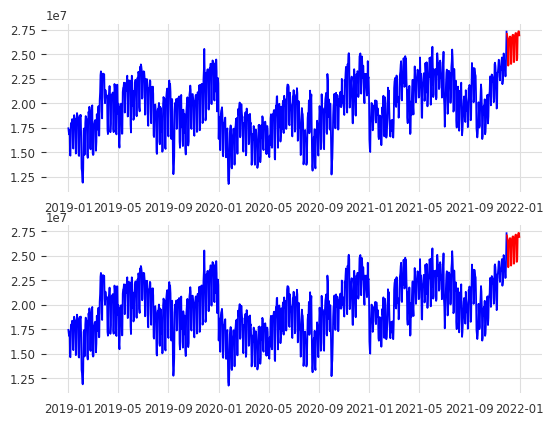

In [ ]:
if run['all'] or run['darts'] or run['submission']:

    submission_model_A = ARIMA(df_A[target],order=(5,1,0),seasonal_order=(2,0,1,7))
    results_A = submission_model_A.fit()
    forecasts_A = results_A.forecast(steps=forecast_steps)
    df_submission_A = pd.DataFrame(forecasts_A)
    # display(df_submission_A)

    fig, axs = plt.subplots(2,1)
    ax1, ax2 = axs
    for ax in axs:
        ax.plot(df_A[target], color="blue", label="actual")
        ax.plot(df_submission_A, color="red", label="predicted")

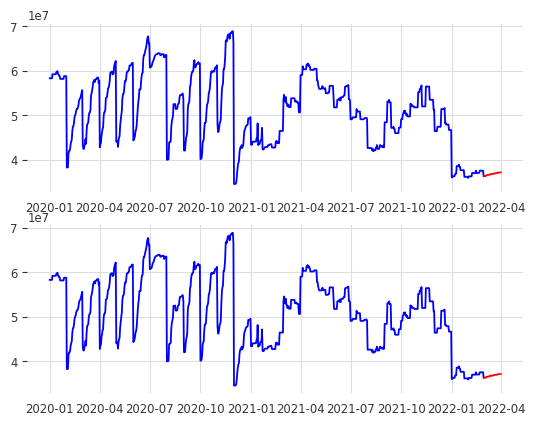

In [ ]:
if run['all'] or run['darts'] or run['submission']:
    
    submission_model_B = ARIMA(df_B[target],order=(5,1,0),seasonal_order=(2,0,1,7))
    results_B = submission_model_B.fit()
    forecasts_B = results_B.forecast(steps=forecast_steps)
    df_submission_B = pd.DataFrame(forecasts_B)
    # display(df_submission_B)

    fig, axs = plt.subplots(2,1)
    ax1, ax2 = axs
    for ax in axs:
        ax.plot(df_B[target], color="blue", label="actual")
        ax.plot(df_submission_B, color="red", label="predicted")

## 5. Deep Learning Models
* Transform time series data further to a three-dimensional array to fit deep learning models

In [ ]:
if run['all'] or run['deep_learning_models']:

    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import *
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.losses import MeanSquaredError
    from tensorflow.keras.metrics import RootMeanSquaredError
    from tensorflow.keras.optimizers import Adam

    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

    def df_to_X_y(df, window_size=3):
        dates = df.iloc[window_size:].index
        df_as_np = df.to_numpy()
        X = []
        y = []
        for i in range(len(df_as_np)-window_size):
            row = [r for r in df_as_np[i:i+window_size]]
            X.append(row)
            label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
            y.append(label)
        return np.array(X).astype(float), np.array(y).astype(float), dates
    
    def train_val_test_split(X, y, dates, forecast_length):
        train_dates, val_dates, test_dates = dates[:2*-forecast_length], dates[2*-forecast_length:-forecast_length], dates[-forecast_length:]
        X_train, y_train = X[:2*-forecast_length], y[:2*-forecast_length]
        X_val, y_val = X[2*-forecast_length:-forecast_length], y[2*-forecast_length:-forecast_length]
        X_test, y_test = X[-forecast_length:], y[-forecast_length:]
        return X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates
    
    def scale_3d_array(train_3d_array, train_scaler=None):
        train_array = train_3d_array.copy()
        if train_scaler:
            for i in range(train_array.shape[2]):
                train_array[:,:,i] = (train_array[:,:,i] - train_scaler[i][0]) / train_scaler[i][1]
            return train_array
        else:
            scaler = []
            for i in range(train_array.shape[2]):
                col_mean = np.mean(train_array[:,:,i])
                col_std = np.std(train_array[:,:,i])
                train_array[:,:,i] = (train_array[:,:,i] - col_mean) / col_std
                scaler.append((col_mean, col_std))
            return train_array, scaler

    def scale_2d_array(train_2d_array, train_scaler=None):
        train_array = train_2d_array.copy()
        if train_scaler:
            for i in range(train_array.shape[1]):
                train_array[:,i] = (train_array[:,i] - train_scaler[i][0]) / train_scaler[i][1]
            return train_array
        else:
            scaler = []
            for i in range(train_array.shape[1]):
                col_mean = np.mean(train_array[:,i])
                col_std = np.std(train_array[:,i])
                train_array[:,i] = (train_array[:,i] - col_mean) / col_std
                scaler.append((col_mean, col_std))
            return train_array, scaler

    def reverse_2d_scaling(scaled_predictions, y_train_scaler):
        reverse_transform = scaled_predictions.copy()
        for i, scale in enumerate(y_train_scaler):
            reverse_transform[:,i] = (reverse_transform[:,i]*scale[1]) + scale[0] 
        return reverse_transform

    def numpy_to_series(name:str, numpy_array, dates):
        series = pd.Series(numpy_array, name=name, index=dates).astype(float)
        pd.options.display.float_format = '{:.10f}'.format
        return series

    def forecast_all_plot(dataset_a, dataset_b, forecasts, fontsize=7, figsize=(6,3), style='default'):
        with plt.style.context(style=style):
            fig = plt.figure(figsize=figsize)
            plt.rcParams.update({'font.size': fontsize})
            plt.rcParams['lines.linewidth'] = 0.3
            plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#e377c2", "#2ca02c", "#bcbd22"])
            dataset_a.plot(legend=True)
            dataset_b.plot(legend=True)
            forecasts.plot(legend=True)
            plt.xlim([dataset_a.index[0], forecasts.index[-1]])
            plt.show()

    def ML_model_evaluation(dataset, forecasts):
        mae = mean_absolute_error(dataset, forecasts)
        mape = mean_absolute_percentage_error(dataset, forecasts)
        rmse = np.sqrt(mean_squared_error(dataset, forecasts))
        print(f"{forecasts.name} mean_absolute_error: {mae:.5f}".format())
        print(f"{forecasts.name} mean_absolute_percentage_error: {mape:.5f}".format())
        print(f"{forecasts.name} rmse: {rmse:.5f}".format())

    def comparison_plot(dataset, forecasts, fontsize=7, figsize=(6,3), style='default'):
        with plt.style.context(style=style):
            fig = plt.figure(figsize=figsize)
            plt.rcParams.update({'font.size': fontsize})
            plt.rcParams['lines.linewidth'] = 0.5
            plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#e377c2", "#2ca02c", "#bcbd22"])
            dataset.plot(legend=True)
            forecasts.plot(legend=True)
            plt.show()

    df_test = df.iloc[:,[-1]+list(range(3))]
    X, y, dates = df_to_X_y(df_test, window_size=4)
    print(X.shape, y.shape)
    
    forecast_length = 31
    X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates = train_val_test_split(X, y, dates, forecast_length)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    X_train_scaled, X_train_scaler = scale_3d_array(X_train)
    y_train_scaled, y_train_scaler = scale_2d_array(y_train)
    X_val_scaled = scale_3d_array(X_val, X_train_scaler)
    y_val_scaled = scale_2d_array(y_val, y_train_scaler)
    X_test_scaled = scale_3d_array(X_test, X_train_scaler)
    y_test_scaled = scale_2d_array(y_test, y_train_scaler)
    print(X_train_scaled.shape, y_train_scaled.shape, X_val_scaled.shape, y_val_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)
    
    model_lstm = Sequential()
    model_lstm.add(InputLayer((4,4)))
    model_lstm.add(LSTM(64))
    model_lstm.add(Dense(8,'relu'))
    model_lstm.add(Dense(2,'linear'))
    # model_lstm.summary()
    
    model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    model_lstm.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=500, batch_size=32)
    predictions = model_lstm.predict(X_test_scaled)
    
    y_train_reverse = reverse_2d_scaling(y_train_scaled, y_train_scaler)
    y_val_reverse = reverse_2d_scaling(y_val_scaled, y_train_scaler)
    y_test_reverse = reverse_2d_scaling(y_test_scaled, y_train_scaler)
    predictions_reverse = reverse_2d_scaling(predictions, y_train_scaler)
    
    y_train_series_a = numpy_to_series("sales(t+1)_train", y_train_reverse[:,0], train_dates)
    y_train_series_b = numpy_to_series("feat_a(t+1)_train", y_train_reverse[:,1], train_dates)
    y_val_series_a = numpy_to_series("sales(t+1)_val", y_val_reverse[:,0], val_dates)
    y_val_series_b = numpy_to_series("feat_a(t+1)_val", y_val_reverse[:,1], val_dates)
    y_test_series_a = numpy_to_series("sales(t+1)_test", y_test_reverse[:,0], test_dates)
    y_test_series_b = numpy_to_series("feat_a(t+1)_test", y_test_reverse[:,1], test_dates)
    predictions_series_a = numpy_to_series("forecasts_a", predictions_reverse[:,0], test_dates)
    predictions_series_b = numpy_to_series("forecasts_b", predictions_reverse[:,1], test_dates)
    
    forecast_all_plot(y_train_series_a, y_val_series_a, predictions_series_a, fontsize=7, figsize=(6,3), style='default')
    forecast_all_plot(y_train_series_b, y_val_series_b, predictions_series_b, fontsize=7, figsize=(6,3), style='default')
    
    ML_model_evaluation(y_test_series_a, predictions_series_a)
    print()
    ML_model_evaluation(y_test_series_b, predictions_series_b)    
    
    comparison_plot(y_test_series_a, predictions_series_a, fontsize=7, figsize=(6,3), style='default')
    comparison_plot(y_test_series_b, predictions_series_b, fontsize=7, figsize=(6,3), style='default')

In [ ]:
if run['all'] or run['recursive_multi_step_forecasting']:

    service = "A"
    from sklearn.model_selection import train_test_split
    from sklearn.neural_network import MLPRegressor

    # dff = df.iloc[-25:,list(range(3))+[-1]]
    # df_short = df.iloc[-10:,-3:]
    # print(df_short)
    target = ['sales']
    features = df.columns[df.columns.str.contains('feat_')].tolist()
    # cols_to_lag = list(set(target + features))
    columns_to_lag = target
    df_train, df_test = train_test_split(df, test_size=31, shuffle=False)
    
    def plot(y_test_pred, filename, lower=None, upper=None):
        # metric
        from sklearn.metrics import mean_squared_error
        rmse = mean_squared_error(df_test[target[0]], y_test_pred, squared=False)    
            
        # Plot
        fig, axs = plt.subplots(2,1)
        ax1, ax2 = axs
        for ax in axs:
            ax.plot(df_test[target[0]], color="blue", label="actual")
            ax.plot(y_test_pred, color="red", label="predicted")
            if lower is not None and upper is not None:
                ax.fill_between(y_test_pred.index, 
                                lower, 
                                upper, 
                                color="k", alpha=.15)    
        df_train[target[0]].plot.line(color="blue")
        ax1.plot([], [], ' ', label=f"RMSE: {rmse}")
        ax1.legend()
        filename = service + "_" + filename
        ax1.set_title(filename)
        plt.savefig(filename + ".png")

    lag = 2
    for col in columns_to_lag:
        for n in range(1, lag + 1):
            col_lag = f"{col}(t-{n})"
            df_train[col_lag] = df_train[col].shift(n)
    # add moving average
    # df_train["moving_avg"] = [df_train.iloc[:i-1,df_train.columns.get_loc(target[0])].mean() if i != 0 else np.nan for i in range(len(df_train[target[0]]))]
    # add month of year
    # df_train["month_of_year"] = df_train.index.month
    # add week of year
    # df_train["week_of_year"] = df_train.index.isocalendar().week
    # add day of week
    # df_train["day_of_week"] = df_train.index.isocalendar().dayofweek
    
    df_train = df_train.dropna().astype(int)
    X_train = df_train.drop(columns=target+features)
    y_train = df_train[target]
    
    # display(X_train)
    # display(y_train)
    
    # create & fit model
    model = MLPRegressor(random_state=0)
    model.fit(X_train, y_train.values.flatten())
    
    X_t = X_train.tail(1).copy()
    for i in range(0,len(columns_to_lag),n):
        X_t.iloc[:,i:i+lag] = X_t.iloc[:,i:i+lag].shift(periods=1, axis="columns")
        X_t.iloc[:,i] = y_train[columns_to_lag[int(i/lag)]].tail(1)
    y_test_pred = []
    for t in range(len(df_test)):
        y_t = model.predict(X_t).astype(int)  # Predict next step
        
        y_test_pred.append(y_t.flatten())  # Store prediction
        pred_num = 0
        for i in range(0,len(columns_to_lag),lag):
            X_t.iloc[:,i:i+lag] = X_t.iloc[:,i:i+lag].shift(periods=1, axis="columns")
            X_t.iloc[:,i] = y_t[pred_num ]  
            pred_num += 1
    # predictions_array = np.asarray(y_test_pred)
    # y_test_plot = pd.Series(predictions_array[:,0], index=df_test.index)
    # plot(y_test_plot, f"MLP_targetonly_lag1-{lag}")

# Appendix

## A. Time Series Feature Engineering Checklist

#### Imputation
* forward fill, backfill
* interpolate

#### Outliers
* identify
* dummy variable

#### Transformation
* log, box, cox
* seasonal & trend adjustment

#### Encoding
* one hot
* target mean, integer

#### Temporal
* calendar day, week, month, holidays
* cyclical feature encoding

#### Past Features
* lag features
* window features

#### Trend & Seasonality
* time variable, changepoint, step changes
* Fourier series, seasonal dummies, seasonal lags

## B. Manual ARIMA Model
* Use differencing and ACF/PACF plots to find values for (p,d,q) used in the ARIMA model
* Model parameters are (p,1,q) if differencing applied to dataset
* Use ACF/PACF plots of the dataset after differencing to determine parameters p,q
* If the PACF plot has significant spike at lag p, but not beyond; and the ACF plot decays more gradually, then this may suggest an ARIMA(p,d,0) model
* If the ACF plot has significant spike at lag q, but not beyond; and the PACF plot decays more gradually, then this may suggest an ARIMA(1,d,0) model

In [ ]:
manual_arima = False

In [ ]:
if manual_arima:

    import datetime

    def get_manual_arima_train_test_split(df, forecast_length):
        df.sort_index(inplace=True,ascending=True)
        df_train = df.iloc[:-forecast_length]
        df_test = df.iloc[-forecast_length:]
        return df_train, df_test

    forecast_length = 31
    df_manual_train, df_manual_test = get_manual_arima_train_test_split(df, forecast_length=forecast_length)
    print(f"df:       min: {df.index.min()}     max: {df.index.max()}     num_days: {(df.index.max()-df.index.min())+datetime.timedelta(days=1)}")
    print(f"df_train: min: {df_manual_train.index.min()}     max: {df_manual_train.index.max()}     num_days: {(df_manual_train.index.max()-df_manual_train.index.min())+datetime.timedelta(days=1)}")
    print(f"df_test:  min: {df_manual_test.index.min()}     max: {df_manual_test.index.max()}     num_days: {(df_manual_test.index.max()-df_manual_test.index.min())+datetime.timedelta(days=1)}")

### B-1. Find model parameters: differencing & ACF/PACF plots

In [ ]:
if manual_arima:

    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(6,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        df_manual_train_diff = df_manual_train.diff().dropna()
        df_manual_train_diff.plot()
        plt.show()

In [ ]:
if manual_arima:

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(8,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        ax_acf = plt.subplot2grid((1,2), (0,0))
        ax_pacf = plt.subplot2grid((1,2), (0,1))

        plot_acf(df_manual_train_diff['sales'],ax=ax_acf)
        plot_pacf(df_manual_train_diff['sales'],method='ywm',ax=ax_pacf)
        plt.show()

In [ ]:
if manual_arima:

    from statsmodels.tsa.stattools import adfuller

    adf = adfuller(df_manual_train_diff['sales'])
    statistic = adf[0]
    p_value = adf[1]
    critical = adf[4]['5%']
    if p_value > 0.05:
        p_stationarity = "time series is not stationary"
    else:
        p_stationarity = "time series is stationary"
    if abs(critical) > abs(statistic):
        c_stationarity = "time series is not stationary"
    else:
        c_stationarity = "time series is stationary"
    print(f"Dickey-Fuller: p={p_value:.5g} ({p_stationarity})".format())
    print(f"Test statistic:  {statistic:.5g} vs 5% critical value: {critical:.5g} ({c_stationarity})".format())

### B-2. Fit ARIMA model
* Fit the ARIMA model after determining (p,d,q) from above
* The ARIMA model from statsmodel.tsa will automatically apply differencing if d is set to 1 so the original dataset is used when fitting the ARIMA model

In [ ]:
if manual_arima:

    from statsmodels.tsa.arima.model import ARIMA
    import warnings
    warnings.filterwarnings('ignore')

    manual_model = ARIMA(df_manual_train['sales'], order=(2,1,0), trend='t')
    model_fit = manual_model.fit()
    display(model_fit.summary())

### B-3. Check model residuals
* Residuals should look randomly distributed and density should have normal distribution

In [ ]:
if manual_arima:
    
    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(8,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        ax_residuals = plt.subplot2grid((1,2), (0,0))
        ax_density = plt.subplot2grid((1,2), (0,1))
        residuals = model_fit.resid[1:]
        residuals.plot(title='Residuals', ax=ax_residuals)
        residuals.plot(title='Density', kind='kde', ax=ax_density)
        plt.show()

* Check the ACF and PACF residual plots to make sure there are no spikes

In [ ]:
if manual_arima:

    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(8,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        ax_acf_residuals = plt.subplot2grid((1,2), (0,0))
        ax_pacf_residuals = plt.subplot2grid((1,2), (0,1))
        acf_residuals = plot_acf(residuals, ax=ax_acf_residuals)
        pacf_residuals = plot_pacf(residuals, ax=ax_pacf_residuals)
        plt.show()

### B-4. Make predictions
* Make predictions from the train set

In [ ]:
if manual_arima:

    manual_forecasts = model_fit.forecast(len(df_manual_test))
    manual_forecasts.name = "manual arima forecasts"

### B-5. Plot forecasts

In [ ]:
if manual_arima:

    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(6,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        df_manual_train['sales'].plot()
        manual_forecasts.plot(color="green")
        plt.legend()
        plt.xlim([df_manual_train['sales'].index[0], manual_forecasts.index[-1]])
        plt.show()

### B-6. Evaluate model predictions

In [ ]:
if manual_arima:

    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

    mae = mean_absolute_error(df_manual_test['sales'], manual_forecasts)
    mape = mean_absolute_percentage_error(df_manual_test['sales'], manual_forecasts)
    rmse = np.sqrt(mean_squared_error(df_manual_test['sales'], manual_forecasts))
    print(f"mean_absolute_error: {mae:.5f}".format())
    print(f"mean_absolute_percentage_error: {mape:.5f}".format())
    print(f"rmse: {rmse:.5f}".format())

In [ ]:
if manual_arima:

    with plt.style.context(style='default'):
        fig = plt.figure(figsize=(6,3))
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['lines.linewidth'] = 0.5

        manual_forecasts.plot(legend=True)
        df_manual_test['sales'].plot(legend=True)
        plt.show()

### C. Recursive forecasting

In [ ]:
recursive_forecasting = False

In [ ]:
if recursive_forecasting:

    service = "A"
    from sklearn.model_selection import train_test_split
    from sklearn.neural_network import MLPRegressor

    # dff = df.iloc[-25:,list(range(3))+[-1]]
    # df_test = df.iloc[-10:,-3:]
    # print(df_test)
    target = ['feat_a', 'feat_b', 'feat_c', 'feat_d', 'feat_e', 'feat_f', 'sales']
    features = df.columns[df.columns.str.contains('feat_')].tolist()
    # cols_to_lag = list(set(target + features))
    columns_to_lag = target

    def plot(y_test_pred, filename, lower=None, upper=None):
        # metric
        from sklearn.metrics import mean_squared_error
        rmse = mean_squared_error(df_test['sales'], y_test_pred, squared=False)    
            
        # Plot
        fig, axs = plt.subplots(2,1)
        ax1, ax2 = axs
        for ax in axs:
            ax.plot(df_test['sales'], color="blue", label="actual")
            ax.plot(y_test_pred, color="red", label="predicted")
            if lower is not None and upper is not None:
                ax.fill_between(y_test_pred.index, 
                                lower, 
                                upper, 
                                color="k", alpha=.15)    
        df_train['sales'].plot.line(color="blue")
        ax1.plot([], [], ' ', label=f"RMSE: {rmse}")
        ax1.legend()
        filename = service + "_" + filename
        ax1.set_title(filename)
        plt.savefig(filename + ".png")

    lag = 28
    df_train, df_test = train_test_split(df, test_size=31, shuffle=False)
    for col in columns_to_lag:
        for n in range(1, lag + 1):
            col_lag = f"{col}(t-{n})"
            df_train [col_lag] = df_train[col].shift(lag)
    df_train = df_train.dropna().astype(int)
    X_train = df_train.drop(columns=target)
    y_train = df_train[target]

    # display(X_train)
    # display(y_train)

    # create & fit model
    model = MLPRegressor(random_state=0)
    model.fit(X_train, y_train)
    X_t = X_train.tail(1).copy()
    for i in range(0,len(X_t.columns),n):
        X_t.iloc[:,i:i+lag] = X_t.iloc[:,i:i+lag].shift(periods=1, axis="columns")
        X_t.iloc[:,i] = y_train[columns_to_lag[int(i/lag)]].tail(1)
    y_test_pred = []
    for t in range(len(df_test)):
        y_t = model.predict(X_t).astype(int)  # Predict next step
        y_test_pred.append(y_t.flatten())  # Store prediction
        pred_num = 0
        for i in range(0,len(X_t.columns),lag):
            X_t.iloc[:,i:i+lag] = X_t.iloc[:,i:i+lag].shift(periods=1, axis="columns")
            X_t.iloc[:,i] = y_t[0][pred_num]
            pred_num += 1
    predictions_array = np.asarray(y_test_pred)
    y_test_plot = pd.Series(predictions_array[:,0], index=df_test.index)
    plot(y_test_plot, f"MLP_allfeatures_lag1-{lag}")
        


### References:

Complete guide on time series analysis:
https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
https://www.kaggle.com/code/hrideshkohli/time-series-forecasting-end-to-end-with-codes

https://medium.com/analytics-vidhya/a-complete-guide-to-time-series-analysis-prologue-6a63fe829263
https://medium.com/analytics-vidhya/a-complete-guide-to-time-series-analysis-story-b56492c47a81


Dataset visualization:
https://medium.com/analytics-vidhya/use-python-to-pull-energy-data-from-the-us-department-of-energys-api-11d6f724927e
https://medium.com/analytics-vidhya/automate-seasonality-plots-with-plotly-and-python-23e7fef065a2

Seasonal decomposition:
https://otexts.com/fpp2/decomposition.html
https://otexts.com/fpp2/residuals.html
https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453


Time series forecasting:
https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
https://medium.com/towards-data-science/time-series-in-python-part-3-forecasting-taxi-trips-with-lstms-277afd4f811
https://towardsdatascience.com/introduction-to-time-series-forecasting-part-1-average-and-smoothing-models-a739d832315
https://towardsdatascience.com/introduction-to-time-series-forecasting-part-2-arima-models-9f47bf0f476b


Time series tests:
https://medium.com/analytics-vidhya/a-complete-guide-to-time-series-analysis-story-b56492c47a81

Auto ARIMA
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

Machine learning models
https://towardsdatascience.com/machine-learning-for-forecasting-transformations-and-feature-extraction-bbbea9de0ac2

https://towardsdatascience.com/how-to-transform-time-series-for-deep-learning-3b6abbbb3726

https://towardsdatascience.com/machine-learning-for-forecasting-supervised-learning-with-multivariate-time-series-b5b5044fe068

Time series cross validation:

https://forecastegy.com/posts/time-series-cross-validation-python/

https://python.plainenglish.io/cross-validation-techniques-for-time-series-data-d1ad7a3a680b

Time series GridSearchCV:

https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci

Recursive multi-step forecasting:

https://www.youtube.com/watch?v=9QtL7m3YS9I

https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=41af8bd7-a5ed-4334-a2fe-992dcc7ea742' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>